In [1]:
import torch as t
import json
from loading_utils import load_examples, load_examples_nopair
from nnsight import LanguageModel

/home/aaron/miniconda3/envs/othello/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/aaron/miniconda3/envs/othello/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
data_basename = "rc_train"
node_threshold = 0.2
edge_threshold = 0.02
data_path = f"/share/projects/dictionary_circuits/data/phenomena/{data_basename}.json"
circuit_path = f"circuits/{data_basename}_dict10_node{node_threshold}_edge{edge_threshold}_n100_aggnone.pt"
model = LanguageModel("EleutherAI/pythia-70m-deduped")
annotations = json.load(open("10_32768_annotations.json", "r"))
circuit = t.load(open(circuit_path, "rb"))
nodes = circuit["nodes"]
edges = circuit["edges"]

length = 6
example = load_examples(data_path, 1, model, length=length)[0]["clean_prefix"]
example = model.tokenizer.batch_decode(example)[0]
circuit = t.load(open(circuit_path, "rb"))

# get min and max node effects
min_effect = min([v.to_tensor().min() for n, v in nodes.items() if n != 'y'])
max_effect = max([v.to_tensor().sum() / 2 for n, v in nodes.items() if n != 'y'])
scale = max(abs(min_effect), abs(max_effect))

# for deciding shade of node
def to_hex(number):
    number = number / scale
    
    # Define how the intensity changes based on the number
    # - Negative numbers increase red component to max
    # - Positive numbers increase blue component to max
    # - 0 results in white
    if number < 0:
        # Increase towards red, full intensity at -1.0
        red = 255
        green = blue = int((1 + number) * 255)  # Increase other components less as it gets more negative
    elif number > 0:
        # Increase towards blue, full intensity at 1.0
        blue = 255
        red = green = int((1 - number) * 255)  # Increase other components less as it gets more positive
    else:
        # Exact 0, resulting in white
        red = green = blue = 255 
    
    print(red, green, blue)

    # decide whether text is black or white depending on darkness of color
    text_hex = "#000000" if (red*0.299 + green*0.587 + blue*0.114) > 170 else "#ffffff"

    # Convert to hex, ensuring each component is 2 digits
    hex_code = f'#{red:02X}{green:02X}{blue:02X}'
    
    return hex_code, text_hex

merges = {"1, Plural noun detectors": ["1, resid_5/8913",
                "1, mlp_4/15560",
                "1, resid_4/8437",
                "1, resid_4/11981",
                "1, resid_3/14779",
                "1, resid_3/10995",
                "1, resid_2/15769",
                "1, resid_2/18001",
                "1, resid_1/2494",
                "1, resid_0/293",
                "1, mlp_0/30990"],
          "1, mlp/resid ε": ["1, mlp_1/ε",
                "1, resid_3/ε",
                "1, resid_4/ε",
                "1, resid_2/ε"],
          "2, attn/resid ε": ["2, attn_2/ε", "2, resid_3/ε"],
          "5, PP/RC boundary detectors": ["5, attn_5/25516",
                                          "5, resid_6/8919",
                                          "5, resid_6/28507",
                                          "5, attn_4/3982"]
}

# nodes_to_sum = ["1, mlp_4/15560",
#                 "1, resid_4/8437",
#                 "1, resid_4/11981",
#                 "1, resid_3/14779",
#                 "1, resid_3/10995",
#                 "1, resid_2/15769",
#                 "1, resid_2/18001",
#                 "1, resid_1/2494",
#                 "1, resid_0/293",
#                 "1, mlp_0/30990"]
# nodes_to_sum = ["1, mlp_1/ε",
#                 "1, resid_3/ε",
#                 "1, resid_4/ε",
#                 "1, resid_2/ε"]
# nodes_to_sum = ["5, attn_4/3982"]
# nodes_to_sum = nodes_to_sum
# effect = 0
# for node in nodes_to_sum:
#     seqpos, node = node.split(", ")
#     submodname, feat_idx = node.split("/")
#     if submodname.startswith("resid"):
#         submodname = submodname[:6] + str(int(submodname[6]) + 1)
#     if submodname.startswith("embed"):
#         submodname = "resid_0"
    
#     if feat_idx == "ε":
#         feat_effect = nodes[submodname].resc[int(seqpos)].item()
#     else:
#         feat_effect = nodes[submodname].act[int(seqpos), int(feat_idx)]
#     effect += feat_effect

# print(effect)
# to_hex(effect)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


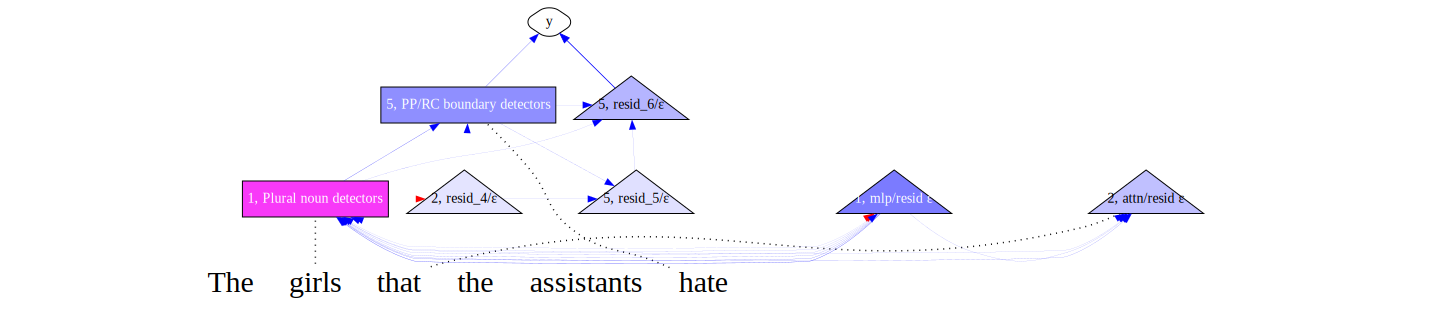

In [23]:
%load_ext autoreload
%autoreload 2
from circuit_plotting import plot_circuit_merge

G = plot_circuit_merge(circuit["nodes"], circuit["edges"], merges, length=length,
                            node_threshold=node_threshold, edge_threshold=edge_threshold,
                            example_text=example, annotations=annotations)
G

In [4]:
def parse_annotations(annotations_path):
    annotations_out = {}
    with open(annotations_path, 'r') as annotations_data:
        for annotation_line in annotations_data:
            annotation = json.loads(annotation_line)
            annotations_out[annotation["Name"]] = annotation[""]

data_basename = "rc_train"
node_threshold = 0.1
edge_threshold = 0.01
data_path = f"/share/projects/dictionary_circuits/data/phenomena/{data_basename}.json"
circuit_path = f"circuits/{data_basename}_dict10_node{node_threshold}_edge{edge_threshold}_n100_aggnone.pt"
model = LanguageModel("EleutherAI/pythia-70m-deduped")
annotations = parse_annotations("annotationsl.json")

length = 6
example = load_examples(data_path, 1, model, length=length)[0]["clean_prefix"]
example = model.tokenizer.batch_decode(example)[0]
circuit = t.load(open(circuit_path, "rb"))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


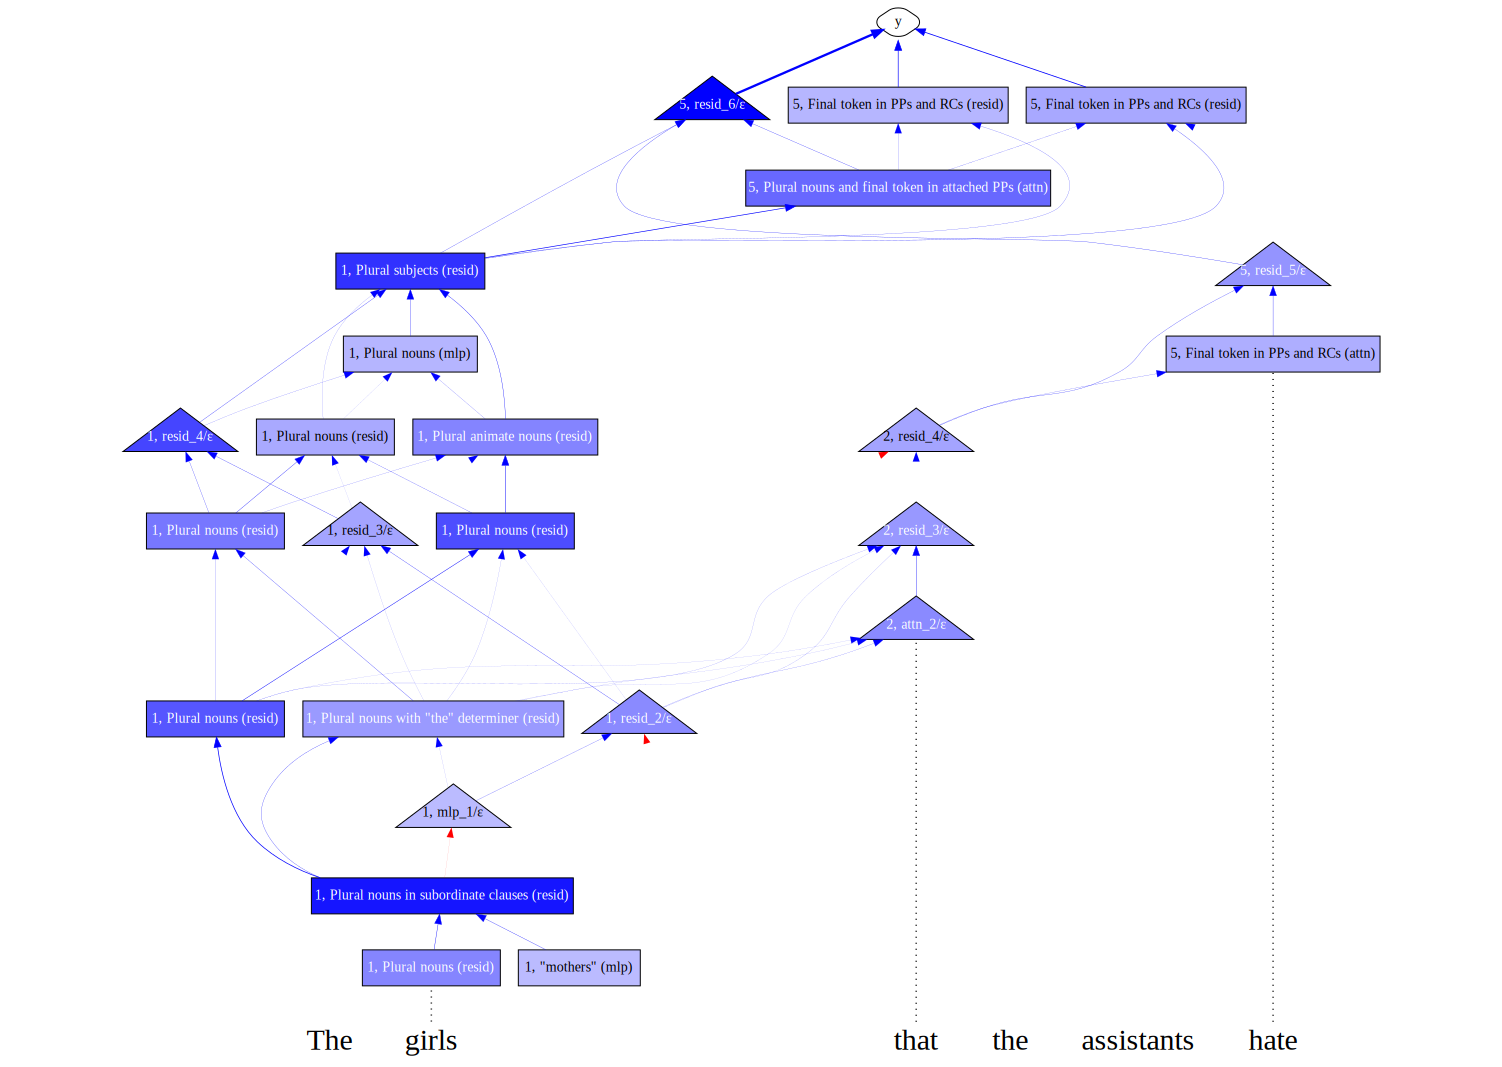

In [7]:
%load_ext autoreload
%autoreload 2
from circuit_plotting import plot_circuit_posaligned

G = plot_circuit_posaligned(circuit["nodes"], circuit["edges"], length=length,
                            node_threshold=node_threshold, edge_threshold=0.01,
                            example_text=example, annotations=annotations)
G

In [52]:
def has_edge(graph, node1, node2):
    tail_name = graph._quote_edge(node1)
    head_name = graph._quote_edge(node2)
    return (graph._edge % (tail_name, head_name, '')) in graph.body

has_edge(G, "girls", "1, resid_0/293")

TypeError: unsupported operand type(s) for %: 'function' and 'tuple'

In [28]:
G.render("rc_noagg", format="png")

'rc_noagg.png'